### Import third-party packages

In [1]:
import torch
import torch.nn as nn
import loralib as lora
from model import CNN
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import optuna
import json
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, max_error
import matplotlib.pyplot as plt
# Determine the equipment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters tuning of LoRA-CT method

In [3]:


def get_peft_model(base_model, lora_rank, lora_alpha):
    np.random.seed(42)
    torch.manual_seed(42)
    class PeftModel(nn.Module):
        def __init__(self, base_model, lora_rank, lora_alpha):
            super(PeftModel, self).__init__()
            for name, module in base_model.named_children():
                if name != 'Linear':
                    self.add_module(name, module)
                else:
                    self.add_module(name, lora.Linear(base_model.Linear.in_features, base_model.Linear.out_features, r=lora_rank, lora_alpha=lora_alpha, merge_weights=True))
            
        def forward(self, x):
            for module in self.children():
                x = module(x)
            return x.squeeze(dim=1)
    
    return PeftModel(base_model, lora_rank, lora_alpha)

def opt_model(trial):
    np.random.seed(42)
    torch.manual_seed(42)
    # Hyperparameter definitions
    learning_rate = trial.suggest_categorical("Learning rate", [1e-5, 1e-4, 1e-3, 1e-2])
    weight_decay = trial.suggest_categorical("Regularization coefficient", [1e-3, 1e-2, 1e-1])
    lora_rank = trial.suggest_categorical("Lora rank", [2, 4, 6, 8])
    lora_alpha = lora_rank 

    X_train = np.load('ethanol-iRaman-data\\iRaman-08_spectra_train.npy')
    y_train= np.load('ethanol-iRaman-data\\iRaman-ethanol_concentrations_train.npy')
    
    X_val = np.load('ethanol-iRaman-data\\iRaman-08_spectra_val.npy')
    y_val= np.load('ethanol-iRaman-data\\iRaman-ethanol_concentrations_val.npy')
    
    X_test = np.load('ethanol-iRaman-data\\iRaman-08_spectra_test.npy')
    y_test= np.load('ethanol-iRaman-data\\iRaman-ethanol_concentrations_test.npy')
    X_train, X_left, y_train, y_left = train_test_split(X_train, y_train, test_size=0.99, random_state=84)
    

    
    # Convert data to tensor and make sure it's on the right device
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=len(y_train), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(y_val), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(y_test), shuffle=False)

    # Load pre-trained model
    model_state_dict = torch.load('ethanol-best_model_cnn_x1.pt', map_location=device, weights_only=True)
    base_model = CNN()
    peft_model = get_peft_model(base_model, lora_rank, lora_alpha).to(device)
    peft_model.load_state_dict(model_state_dict, strict=False)
    
    # Perform weight decay
    original_weight = peft_model.Linear.weight.data
    decayed_weight = original_weight * 0.5
    peft_model.Linear.weight.data = decayed_weight
    #Confirm the layers to be trained
    lora.mark_only_lora_as_trainable(peft_model)

    optimizer = torch.optim.AdamW(peft_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = nn.SmoothL1Loss().to(device)
    epochs = 100

    for epoch in range(epochs):
        peft_model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.unsqueeze(dim=1).to(device)
            batch_y = batch_y.to(device)
            outputs = peft_model(batch_x)
            loss = loss_fn(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    peft_model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.unsqueeze(dim=1).to(device)
            batch_y = batch_y.to(device)
            output = peft_model(batch_x)
            predictions.extend(output.cpu().tolist())
            actuals.extend(batch_y.cpu().tolist())

    if len(predictions) >= 2:
        r2 = r2_score(actuals, predictions)
    return r2

# hyperparameters tuning
study = optuna.create_study(direction="maximize")
study.optimize(opt_model, n_trials=50)
print('Optimal hyperparameter results:', study.best_params)

# Save the best hyperparameters
best_params = study.best_params
with open('iRaman-08-lora_peft_best_hyperparameters_1%.json', 'w') as f:
    json.dump(best_params, f)

[I 2025-02-17 18:48:05,283] A new study created in memory with name: no-name-86ae0fd1-cb09-4af6-b8f8-7f8872608b8f
[I 2025-02-17 18:48:07,064] Trial 0 finished with value: 0.9821283124200934 and parameters: {'Learning rate': 0.001, 'Regularization coefficient': 0.01, 'Lora rank': 8}. Best is trial 0 with value: 0.9821283124200934.
[I 2025-02-17 18:48:07,670] Trial 1 finished with value: 0.9806544188636096 and parameters: {'Learning rate': 0.001, 'Regularization coefficient': 0.1, 'Lora rank': 4}. Best is trial 0 with value: 0.9821283124200934.
[I 2025-02-17 18:48:08,273] Trial 2 finished with value: 0.9814698335878639 and parameters: {'Learning rate': 0.001, 'Regularization coefficient': 0.1, 'Lora rank': 2}. Best is trial 0 with value: 0.9821283124200934.
[I 2025-02-17 18:48:08,875] Trial 3 finished with value: 0.9796721750825058 and parameters: {'Learning rate': 0.0001, 'Regularization coefficient': 0.001, 'Lora rank': 2}. Best is trial 0 with value: 0.9821283124200934.
[I 2025-02-17 

Optimal hyperparameter results: {'Learning rate': 0.001, 'Regularization coefficient': 0.001, 'Lora rank': 8}


### Load the optimal combination of hyperparameters of the LoRA-CT method for fine-tuned training

Epoch 1, Train Loss: 0.03473100811243057, Val Loss: 0.029783116653561592
Epoch 2, Train Loss: 0.01653461344540119, Val Loss: 0.03457430377602577
Epoch 3, Train Loss: 0.16667848825454712, Val Loss: 0.013579890131950378
Epoch 4, Train Loss: 0.0011700440663844347, Val Loss: 0.04219120368361473
Epoch 5, Train Loss: 0.038016945123672485, Val Loss: 0.045979131013154984
Epoch 6, Train Loss: 0.04806973412632942, Val Loss: 0.02961876429617405
Epoch 7, Train Loss: 0.025329619646072388, Val Loss: 0.01120793353766203
Epoch 8, Train Loss: 0.0051300134509801865, Val Loss: 0.013762987218797207
Epoch 9, Train Loss: 0.029899269342422485, Val Loss: 0.021475818008184433
Epoch 10, Train Loss: 0.05068081617355347, Val Loss: 0.012297971174120903
Epoch 11, Train Loss: 0.02533760853111744, Val Loss: 0.007584553211927414
Epoch 12, Train Loss: 0.006160000339150429, Val Loss: 0.012795733287930489
Epoch 13, Train Loss: 0.007692157290875912, Val Loss: 0.019884563982486725
Epoch 14, Train Loss: 0.015317359939217567

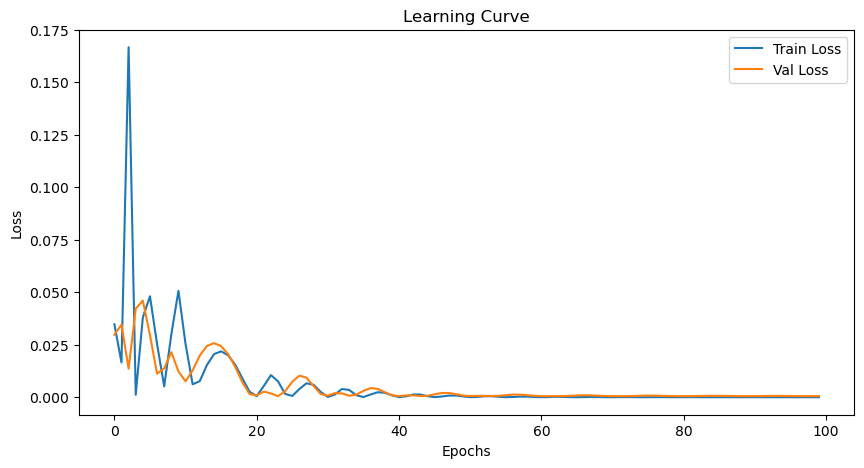

Training set evaluation results:
R2: 0.9997919277257847, RMSEP: 0.0032485135379186334, MAE: 0.002486368641257286, MAX_ERROR: 0.006846681237220764
Validation set evaluation results:
R2: 0.9821292313034196, RMSEP: 0.033009587940650405, MAE: 0.019685757518918427, MAX_ERROR: 0.15143054723739624
Test set evaluation results:
R2: 0.9709574030224138, RMSEP: 0.037110156545750075, MAE: 0.01969669936224818, MAX_ERROR: 0.1997935175895691


In [4]:

def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=len(y_train), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=len(y_val), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(y_test), shuffle=False)

    return train_loader, val_loader, test_loader

def get_peft_model(base_model, lora_rank, lora_alpha):
    class PeftModel(nn.Module):
        np.random.seed(42)
        torch.manual_seed(42)
        def __init__(self, base_model, lora_rank, lora_alpha):
            super(PeftModel, self).__init__()
            for name, module in base_model.named_children():
                if name != 'Linear':
                    self.add_module(name, module)
                else:
                    self.add_module(name, lora.Linear(base_model.Linear.in_features, base_model.Linear.out_features, r=lora_rank, lora_alpha=lora_alpha, merge_weights=True))
            
        def forward(self, x):
            for module in self.children():
                x = module(x)
            return x.squeeze(dim=1)
    
    return PeftModel(base_model, lora_rank, lora_alpha)

def train_model(model, train_loader, val_loader, learning_rate, weight_decay):
    model.to(device)
    loss_fn = nn.SmoothL1Loss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    epochs = 100
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.unsqueeze(dim=1).to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.unsqueeze(dim=1).to(device)
                batch_y = batch_y.to(device)
                output = model(batch_x)
                loss = loss_fn(output, batch_y)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')
    
    return train_losses, val_losses

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.unsqueeze(dim=1).to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            predictions.extend(output.cpu().tolist())
            actuals.extend(batch_y.cpu().tolist())
    final_r2 = r2_score(actuals, predictions)
    RMSEP = root_mean_squared_error(actuals, predictions)
    MAE = mean_absolute_error(actuals, predictions)
    MAX_ERROR = max_error(actuals, predictions)
    return final_r2, RMSEP, MAE, MAX_ERROR

def save_model(model, filename):
    torch.save(model.state_dict(), filename)


def main():
    with open('iRaman-08-lora_peft_best_hyperparameters_1%.json', 'r') as f:
        best_params = json.load(f)
    
    learning_rate = best_params['Learning rate']
    weight_decay = best_params['Regularization coefficient']
    lora_rank = int(best_params['Lora rank'])
    lora_alpha = lora_rank
    np.random.seed(42)
    torch.manual_seed(42)
    X_train = np.load('ethanol-iRaman-data\\iRaman-08_spectra_train.npy')
    y_train= np.load('ethanol-iRaman-data\\iRaman-ethanol_concentrations_train.npy')
    
    X_val = np.load('ethanol-iRaman-data\\iRaman-08_spectra_val.npy')
    y_val= np.load('ethanol-iRaman-data\\iRaman-ethanol_concentrations_val.npy')
    
    X_test = np.load('ethanol-iRaman-data\\iRaman-08_spectra_test.npy')
    y_test= np.load('ethanol-iRaman-data\\iRaman-ethanol_concentrations_test.npy')
    X_train, X_left, y_train, y_left = train_test_split(X_train, y_train, test_size=0.99, random_state=84)
    train_loader, val_loader, test_loader = create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test)
    
    base_model = CNN()
    peft_model = get_peft_model(base_model, lora_rank, lora_alpha)

    model_state_dict = torch.load('ethanol-best_model_cnn_x1.pt', map_location=device, weights_only=True)
    peft_model.load_state_dict(model_state_dict, strict=False)
    # Perform weight decay
    original_weight = peft_model.Linear.weight.data
    decayed_weight = original_weight * 0.5
    peft_model.Linear.weight.data = decayed_weight

    lora.mark_only_lora_as_trainable(peft_model)

    peft_model = peft_model.to(device)
    train_losses, val_losses = train_model(peft_model, train_loader, val_loader,learning_rate, weight_decay)
    plot_learning_curve(train_losses, val_losses)

    print('Training set evaluation results:')
    r2, rmse, mae, me = evaluate_model(peft_model, train_loader, device)
    print(f'R2: {r2}, RMSEP: {rmse}, MAE: {mae}, MAX_ERROR: {me}')

    print('Validation set evaluation results:')
    r2, rmse, mae, me = evaluate_model(peft_model, val_loader, device)
    print(f'R2: {r2}, RMSEP: {rmse}, MAE: {mae}, MAX_ERROR: {me}')

    print('Test set evaluation results:')
    r2, rmse, mae, me = evaluate_model(peft_model, test_loader, device)
    print(f'R2: {r2}, RMSEP: {rmse}, MAE: {mae}, MAX_ERROR: {me}')
    
   
    # Save the weights of the lora module
    torch.save(lora.lora_state_dict(peft_model), 'iRaman-08-lora_state_dict_1%.pt')
    save_dict = {}
    # Save the weights of the fine-tuned BN layer
    model_state = peft_model.state_dict()
    for k,v in model_state.items():
        if 'BatchNorm' in k:
            save_dict[k] = v
    torch.save(save_dict, 'iRaman-08-peft_model_BN_1%.pt')
if __name__ == '__main__':
    main()